<a href="https://colab.research.google.com/github/HanSeoulOh/mathproblems/blob/master/stochasticGraphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Processes in Graphs
##### Han Du

The purposes of this notebook is to study stochastic processes and algorithms on graphs.

We will study random graphs $G = (N, p)$ where $N$ is fixed number of vertices and $p$ represents the probability of an edge being included.

We will represent graphs as an adjacency matrix $A$ of $G$.

$A_{i,j} = 1$ if there is an interaction between node i and node j.

$A_{i,i}$ represents the value stored by node i.


####Helper Code

In [0]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import pandas as pd


# graph initialization

n = 10
p = 0.5

def initializeGraph(n, p):
    upperDiagIndices = np.triu_indices(n, 1)
    A = np.zeros((n, n))
    return upperDiagIndices, A

def randomizeEdges(A, n, p):
    m = map((lambda x: x < p), np.random.rand(int((n-1) * n / 2)))
    edges = np.array([1 if e else 0 for e in m])
    A[upperDiagIndices] = edges
    return A


def randomAccumulate(A, n, p):
    randIdx = np.random.randint(low = 0, high = n)
    A[randIdx, randIdx] += 1
    return A


def drawGraph(A):
    nxA = nx.from_numpy_matrix(A)
    labelDict = dict(zip(nxA, np.diag(A).astype(int).tolist()))
    nx.draw(nxA, labels = labelDict)
    ax = plt.gca()
    ax.set_aspect('equal')


def oneStepPropagation(A):
    changed = []
    for i, row in enumerate(A):
        for j, column in enumerate(row):
            if i != j:
                if A[i, j] == 1 and i not in changed and j not in changed:
                    maxIJ = max(A[i, i], A[j, j])
                    if A[i, i] < maxIJ:
                        changed.append(i)
                    elif A[j, j] < maxIJ:
                        changed.append(j)
                    else:
                      pass
                    A[i, i] = maxIJ
                    A[j, j] = maxIJ
    return A
    # print(changed)


def checkAllEqual(A):
    return (np.diag(A) == A[0,0]).all()



### Generating Degree Sequences

The degree sequence of an undirected graph is the non-increasing sequence of its vertex degrees.
The degree sequence is a graph invariant so isomorphic graphs have the same degree sequence.
In some cases, non-isomorphic graphs have the same degree sequence.

In a $k$-connected graph of $N$ edges, we have a degree sequence $S = (k, ..., k)$ where $|S| = N$





## Constant Information Propagation in a Random Network from a Single Source

We start with studying the speed of information propagation in a graph where values of nodes are updated by the rule:

$A_{i,j} = 1 \implies \max{(A_{i,i},A_{j,j})} \rightarrow A_{i,i}, A_{j,j}$

After an adjacent node is updated, those nodes do not update adjacent nodes until the next time step or iteration of the propagation rule.

### Constant information

In this section we study how quickly constant information $C$ propagates in a constant sized graph $G = (N, p)$

i.e. how many timesteps or iterations of the update rule it takes before $A_{i, i} = A_{j, j} \; \forall \, i,j \in E(G)$


In [0]:
queue = []
iterations = 100000
for i in range(iterations):
    count = 0
    upperDiagIndices, A = initializeGraph(n, p)
    A = randomizeEdges(A, n, p)
    A = randomAccumulate(A, n, p)
    # print(A)
    while not checkAllEqual(A):
        A = randomizeEdges(A, n, p)
        A = oneStepPropagation(A)
        # print(A)
        count +=1
    queue.append(count)
    count = 0

average = sum(queue)/iterations
print("It takes on average " + str(average) + " iterations until the entire network has updated in value.")

It takes on average 2.16696 iterations until the entire network has updated in value.


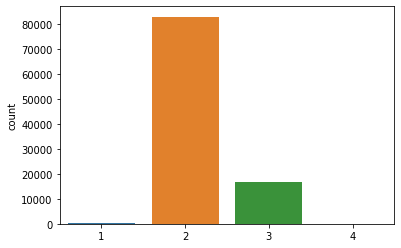

In [0]:
sns.countplot(list(map(int, queue)))

### Incrementing information

Here we introduce a new concept of incrementing information:

i.e. $C_t \geq C_{t-1} \; \forall t$

Where $t$ is time and $C_t$ is determined by an arbitrary monotonically increasing function $f(t)$

We measure the lag $L$ by:

$\displaystyle L(G_t) = \sum_{i}^{N}{C_t - A_{i,i}}$

For our simulation, we select $f(t) = t$

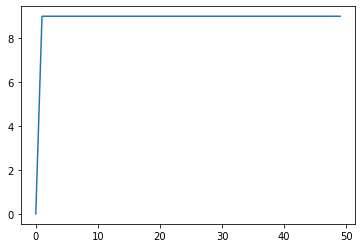

In [0]:
def randomAssign(A, n, p, t):
    randIdx = np.random.randint(low = 0, high = n)
    A[randIdx, randIdx] = t
    return A

def lag(A, t):
    return sum(np.ones(np.diag(A).shape) * t - np.diag(A))


def f(timestep):
    return timestep

maxTime = 50
iterations = 1000
n = 10
p = 1
lags = np.zeros((iterations, maxTime))
for iter in range(iterations):
    count = 0
    upperDiagIndices, A = initializeGraph(n, p)
    A = randomizeEdges(A, n, p)
    # print(A)
    while count < maxTime:
        A = oneStepPropagation(A)
        A = randomizeEdges(A, n, p)
        A = randomAssign(A, n, p, count)
        lags[iter, count] = lag(A, count)
        count += 1
    count = 0


sns.lineplot(data=pd.DataFrame(lags).mean())

## Constant Information Propagation in k-degree uniform Graphs from a Single Source

Here we will study the speed of the propagation of a constant information packet in a $k$-connected random graph, using the same information update rule as previous sections.

In this section we study how quickly constant information $C$ propagates in a k connected graph $G$ constructed from the degree sequence $(k, ..., k)$

i.e. how many timesteps or iterations of the update rule it takes before $A_{i, i} = A_{j, j} \; \forall \, i,j \in E(G)$


In [0]:
sequence = [3 for i in range(10)]
queue = []
iterations = 10000
for i in range(iterations):
    count = 0
    A = nx.to_numpy_matrix(nx.random_degree_sequence_graph(sequence))
    # print(A)
    A = randomAccumulate(A, n, p)
    while not checkAllEqual(A) and count < 100:
        A = oneStepPropagation(A)
        D = np.diag(A)
        # print(A)
        count +=1
        A = nx.to_numpy_matrix(nx.random_degree_sequence_graph(sequence))
        A[np.diag_indices(n)] = np.asmatrix(D)
    queue.append(count)
    count = 0

average = sum(queue)/iterations
print("It takes on average " + str(average) + " iterations until the entire network has updated in value.")

It takes on average 10.2109 iterations until the entire network has updated in value.


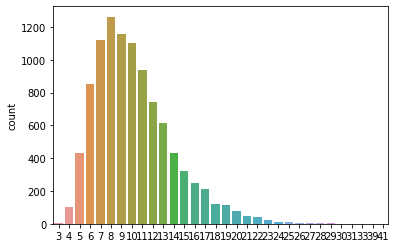

In [0]:
sns.countplot(list(map(int, queue)))

In [0]:
print("standard deviation: " + str(np.std(queue)))

standard deviation: 3.74251535601392


## Constant Information Propagation in $\sim$K-Connected Graphs from a Single Source

In this section we study how quickly constant information $C$ propagates in a random k connected graph $G$ constructed from the degree sequence $(d_1, ..., d_n)$ where $d_i \leq k$

i.e. how many timesteps or iterations of the update rule it takes before $A_{i, i} = A_{j, j} \; \forall \, i,j \in E(G)$


#### Generating k-connected graphs

In [0]:
k = 3
queue = []
iterations = 10000
dsList = []

graphList = []
for i in range(iterations):
    sequence = np.random.poisson(k, 10) + 1
    sequence = np.flip(np.sort(sequence))
    dsList.append(sequence)



In [0]:
validDSList = []
for sequence in dsList:
    if nx.is_graphical(np.flip(np.sort(sequence))):
      validDSList.append(sequence)

In [0]:
for sequence in validDSList:
    try:
      G = nx.random_degree_sequence_graph(sequence, None, 1)
      if nx.is_connected(G):
        A = nx.to_numpy_matrix(G)
        graphList.append(A)
    except:
      pass
    

In [0]:
len(graphList)

988

#### Code for running the simulation

In [0]:
import random
for graph in graphList:
    count = 0
    A = np.zeros((n,n)) + graph
    # print(A)
    A = randomAccumulate(A, n, p)
    while not checkAllEqual(A) and count < 100:
        A = oneStepPropagation(A)
        D = np.diag(A)
        # print(A)
        count +=1
        A = np.zeros((n,n)) + random.choice(graphList)
        A[np.diag_indices(n)] = np.asmatrix(D)
    queue.append(count)
    count = 0


It takes on average 0.5012 iterations until the entire network has updated in value.


#### Output

In [0]:

average = sum(queue)/iterations
print("It takes on average " + str(average) + " iterations until the entire network has updated in value.")

It takes on average 0.5012 iterations until the entire network has updated in value.


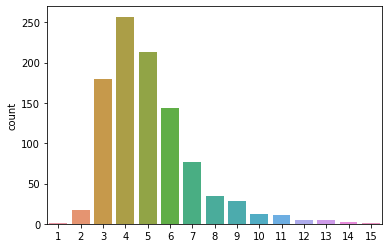

In [0]:
sns.countplot(list(map(int, queue)))

# Sequential Information Propagation in Network

Here we make the following assumptions:

Only the 0th node updates in terms of the count information. All other nodes must indirectly update in the count by either interacting directly with the 0th node or another node that has the updated count.

The below assumes that the count increments for each day.

In [37]:
import pandas as pd
import numpy as np
population = 1000
tx = 3000
days = 500
val = np.zeros(population)
seq = np.zeros(days)
seq2 = np.zeros(days)
seq3 = np.zeros(days)

for day in range(days):
  # print(val)
  trans = pd.DataFrame(data = np.array([np.random.randint(population, size=tx), np.random.randint(population, size=tx)]).T, columns = ['sender', 'receiver'])
  val[0] += 1
  for index, row in trans.iterrows():
    tmax = max(val[row['sender']], val[row['receiver']])
    val[row['sender']] = tmax
    val[row['receiver']] = tmax
  seq[day] = np.average(val)
  seq2[day] = max(val) - min(val)
  seq3[day] = day - np.average(val)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

    Real Time  Propagated Time
0    0.000000            0.493
1    1.020408            1.024
2    2.040816            1.943
3    3.061224            3.187
4    4.081633            4.189
5    5.102041            5.387
6    6.122449            6.295
7    7.142857            7.440
8    8.163265            8.146
9    9.183673            9.007
10  10.204082           10.265
11  11.224490           11.099
12  12.244898           12.478
13  13.265306           13.333
14  14.285714           14.398
15  15.306122           15.478
16  16.326531           16.127
17  17.346939           17.050
18  18.367347           18.231
19  19.387755           19.133
20  20.408163           20.402
21  21.428571           21.402
22  22.448980           22.428
23  23.469388           23.141
24  24.489796           24.061
25  25.510204           25.247
26  26.530612           26.066
27  27.551020           27.292
28  28.571429           28.186
29  29.591837           29.280
30  30.612245           30.222
31  31.6

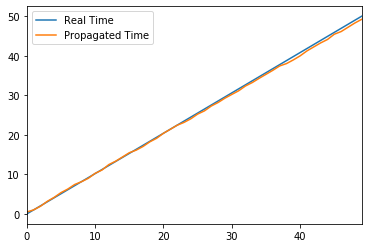

In [48]:
rseq = np.linspace(0, days)
con = pd.DataFrame(data = {'Real Time' : rseq, 'Propagated Time': seq})
# print(con)
con.plot()

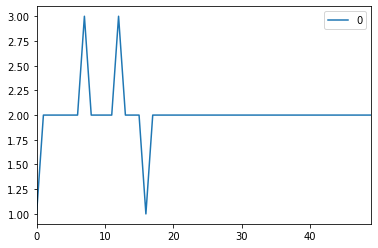

In [36]:
pd.DataFrame(seq2).plot()

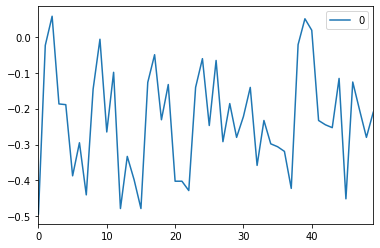

In [38]:
pd.DataFrame(seq3).plot()

Below assumes that count increments with each transaction.

We are concerned if there is a nonconstant growth between the distance of the starting count of each day, and the smallest count in the network

In [0]:
population = 1000
tx = 3000
days = 500
val = np.zeros(population)
seq = np.zeros(days)
seq2 = np.zeros(days)
seq3 = np.zeros(days)

for day in range(days):
  # print(val)
  trans = pd.DataFrame(data = np.array([np.random.randint(population, size=tx), np.random.randint(population, size=tx)]).T, columns = ['sender', 'receiver'])
  for index, row in trans.iterrows():
    val[0] += 1
    tmax = max(val[row['sender']], val[row['receiver']])
    val[row['sender']] = tmax
    val[row['receiver']] = tmax
  seq[day] = np.average(val)
  seq2[day] = max(val) - min(val)
  seq3[day] = day*tx - np.average(val)


Here we plot the Real Time vs. the average time reported by each node and notice that they are approximately equal

500
500


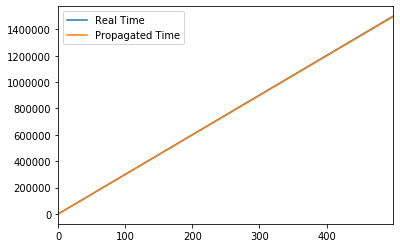

In [71]:
rseq = np.linspace(0, days*tx, num = days)
print(len(rseq))
print(len(seq))
con = pd.DataFrame(data = {'Real Time' : rseq, 'Propagated Time': seq})
con.plot()

This is further evidenced by plotting the max distance from the real time and difference between the mean time reported by nodes from the real time, both showing a stationary relationship, meaning over time, there is a approximately a constant amount of distance from the actual time.

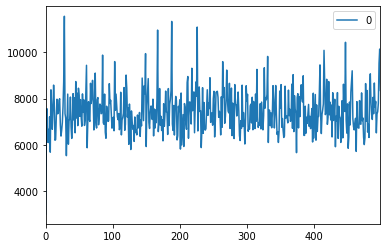

In [72]:
pd.DataFrame(seq2).plot()

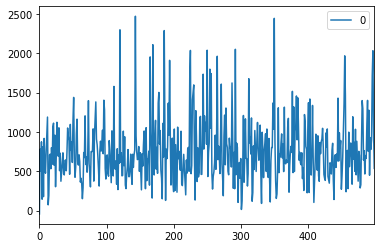

In [73]:
pd.DataFrame(seq3).plot()

In [77]:
np.average(seq2)

7435.5

In [78]:
np.average(seq3)

758.994820000004